# PTM PPI Shortcut analysis

In [1]:
import sys, pandas as pd, os, matplotlib.pyplot as plt, sklearn
from sklearn import tree

sys.path.append("../src")
from utils.s3_utils import download_file



all_labels = list(range(7))
pos_labels = list(range(1,7,1))
label_names = ["other",
                            "phosphorylation",
                            "dephosphorylation",
                            "methylation",
                            "ubiquitination",
                            "acetylation",
                            "deubiquitination"]

renamed_labels = ["Negative"] + [i.title() for i in label_names[1:]]

ptm_trigger_words =  ["phosphorylation", "deubiquitination", "acetylation", "ubiquitination", "methylation", "dephosphorylation"]



## Original inputs with markers
For how to create the preprocessed file for PTM-PPI, see https://github.com/elangovana/large-scale-ptm-ppi/blob/main/src/utils/static_markers_ppi_multiclass.py

In [2]:
temp_dir = "temp"

In [3]:
trainfile="../temp/markers_train_multiclass.json"
testfile="../temp/markers_test_multiclass.json"
valfile="../temp/markers_val_multiclass.json"


In [4]:
s3_generalisation = "s3://aegovan-data/pubmed_asbtract/predictions_largescale_ppimulticlass-bert-f1-2021-05-10-10_2022-07-01_negative_generalisation/"
s3_large_scale_high_q = "{}/highquality_sample.json".format(s3_generalisation.rstrip("/"))
s3_large_scale_low_q = "{}/lowquality_sample.json".format(s3_generalisation.rstrip("/"))

## Predictions with markers

In [5]:
largescalefile = "../temp/markers_largescale_hq_above_threshold.json"
largescale_low_hq="../temp/markers_largescale_lq_below_threshold.json"

test_predictions_file ="../temp/markers_test_pred_multiclass.json"

In [6]:
def load_large_scale(file, labels_order = label_names):
    df = pd.read_json(file, orient="records")
    df["y"] = df["prediction"].apply(lambda x: labels_order.index(x) )
    df["y_raw"] = df["prediction"]


    return df

def load_valtest_ensemble_pred(file, labels_order = label_names):
    df = pd.read_json(file, orient="records")
    df["y"] = df["prediction"].apply(lambda x: labels_order.index(x) )
    df["y_raw"] = df["prediction"]


    return df

In [7]:
from model_nb_relation_classifier import ModelNBRelationClassifier
from model_nb_tree_relation_classifier import ModelNBTreeRelationClassifier
from model_tree_relation_classifier import ModelTreeRelationClassifier

NAIVE_BAYES="Naive Bayes"
NAIVE_BAYES_WITH_TREE = "Naive Bayes + Tree"
TREE = "Tree"


def  train_and_predict_all_classifiers(df, min_df=None):
    
    max_words_per_class = 10
    max_tree_depth = 4
    
    classifiers = {
        NAIVE_BAYES : ModelNBRelationClassifier("PROTPART1", "PROTPART0", max_words_per_class=max_words_per_class, min_df=min_df),
        NAIVE_BAYES_WITH_TREE : ModelNBTreeRelationClassifier("PROTPART1", "PROTPART0", min_df=min_df, max_words_per_class=max_words_per_class, trigger_words=ptm_trigger_words, max_tree_depth=max_tree_depth),
        TREE : ModelTreeRelationClassifier("PROTPART1", "PROTPART0",  trigger_words=ptm_trigger_words, max_tree_depth=max_tree_depth)

    }
   
    
    result = {}
    for k, m in classifiers.items():
        
        print(f"Training {k}")
        
        m.train(df["x"], df["y"])
        p, p_conf = m.predict(df["x"])
        result[k] = {
            "m" : m,
            "predictions" : p,
            "predictions_conf": p_conf
        }
    return result

def  predict_all_classifiers(df, models_dict):
    max_words_per_class = 10
    max_tree_depth = 4
    
   
    
    result = {}
    for k, v in models_dict.items():
        m = v["m"]
        
        p, p_conf = m.predict(df["x"])
        result[k] = {
            "m" : m,
            "predictions" : p,
            "predictions_conf": p_conf
        }
    return result


In [8]:
def isint(a):
    try:
        t = int(a)
        return True
    except:
        return False
    
def float_percent_format(x):
     return "{:.1f}".format(x*100)

def int_format(x):
     return str(int(x))

def print_report(actual, pred, labels=None, label_names = renamed_labels):

    pos_f1 = sklearn.metrics.f1_score(actual, pred, labels=labels, average='micro',
                                  sample_weight=None, zero_division=0)
    all_f1 = sklearn.metrics.f1_score(actual, pred, average='micro', sample_weight=None, zero_division=0)
    
        
    d = sklearn.metrics.classification_report(actual,
                                            pred,
                                            output_dict=True,
                                            labels=labels,zero_division=0)
    df =  pd.DataFrame(d).T
    df.index = list(map(lambda x: label_names[int(x)] if isint( x) else x, df.index))
    df.insert(1, "index", df.index)


    return df
    
def print_report_all_classifiers(actual, results_dict, *args, **kwargs):
    result = []
    for k, v in results_dict.items():
        df = print_report(actual,v["predictions"],  *args, **kwargs)
        df.insert (0, "model", k)
        
        result.append(df)
    df = pd.concat(result)
    print(df.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format }))
    return df
        
        

In [9]:
def prep_data(df, m):
    df_t = df.copy(deep=True)
    df_t["nb_pred"] = m["predictions"]
    df_t["nb_pred_conf"] = m["predictions_conf"]
    df_t["nb_pred_raw"] = df_t["nb_pred"].apply(lambda i: label_names[i])
    return df_t

def plot_confidence(df_t):
    labels =  list(df_t["y_raw"].unique())   
    print(labels)
    _ , ax = plt.subplots(len(labels),1, figsize=(10,15))



    for i,l in enumerate(labels):
        t = df_t.query(f"y_raw == '{l}'")

        ax[i].set_ylim(0,1)


        ax[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

        ax[i].spines['bottom'].set_color('grey')
        ax[i].spines['top'].set_color('grey') 
        ax[i].spines['right'].set_color('grey')
        ax[i].spines['left'].set_color('grey')



        ax[i].violinplot(t["confidence"],  showmeans=True )
        ax[i].set_title(f"{l}")


# plot_confidence(prep_data(df_largescale_hq, result_largescale_hq[NAIVE_BAYES_WITH_TREE]))

# plt.show()




In [10]:
from dtreeviz.trees import *

def plot_tree(m):
    _, ax = plt.subplots(1,1, figsize=(45,15))

    tree.plot_tree(m.tree_model, ax=ax, fontsize=10, feature_names=m.feature_names, filled=True, rounded=True)

    plt.show()
    
def plot_tree_pretty(m, x, y, title="", image_save_path=None):
    import sys
    dot_path = '/opt/homebrew/bin/'
    if dot_path not in sys.path :
        sys.path.append( dot_path)
        for p in sys.path:
            os.environ["PATH"] = os.environ.get("PATH","") + ":" +  p

    viz = dtreeviz(m.tree_model,
               x_data=m.extract_features(x),
               y_data=y,
               target_name='class',
               feature_names=m.feature_names,
               class_names=label_names,
               title=title)
    
    return viz
    # tree_plt.view()    
    if image_save_path:
        tree_plt.save(image_save_path)

In [11]:
def get_top_discrimintary_keywords(model, label_index ) :
    index_to_vocab = {i:v  for v,i in model.vocab.items()}

    return sorted( [ (index_to_vocab[i],p) for i,p in enumerate(model.nb_model.feature_log_prob_[label_index])], 
           reverse=True, key=lambda x: x[1])[:50]




In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def consolidate_label_names(actual, pred, label_names):
    label_indices = list(set(actual).union(pred))
    return [label_names[i] for i in sorted(label_indices)]

def plot_confusionmatrix(y_true,y_pred):
    cm = confusion_matrix(y_true,y_pred)
    labels = consolidate_label_names( y_true,y_pred,label_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
    disp.plot(cmap="PuBu", xticks_rotation="vertical")
    

## Train GT Train predictions

In [13]:
df_train = pd.read_json(trainfile, orient="records")
train_result = train_and_predict_all_classifiers(df_train)

print_report_all_classifiers(df_train["y"], train_result,  pos_labels)

print_report_all_classifiers(df_train["y"], train_result,  all_labels)



Training Naive Bayes
Max words :  29
Training Naive Bayes + Tree
Training Tree
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      35.2 &   Phosphorylation &   64.0 &     45.4 &     139 \\
       Naive Bayes &      17.6 & Dephosphorylation &   32.1 &     22.8 &      28 \\
       Naive Bayes &      31.2 &       Methylation &  100.0 &     47.6 &      10 \\
       Naive Bayes &      27.8 &    Ubiquitination &  100.0 &     43.5 &       5 \\
       Naive Bayes &      15.2 &       Acetylation &  100.0 &     26.3 &       5 \\
       Naive Bayes &      33.3 &  Deubiquitination &  100.0 &     50.0 &       2 \\
       Naive Bayes &      30.5 &         micro avg &   63.5 &     41.2 &     189 \\
       Naive Bayes &      26.7 &         macro avg &   82.7 &     39.3 &     189 \\
       Naive Bayes &      31.6 &      weighted avg &   63.5 &     41.7 &     189 \\
Naive Bayes + Tree &      70.2 &   Phos

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.951754,Negative,0.777778,0.856016,1116.000000
Phosphorylation,Naive Bayes,0.351779,Phosphorylation,0.640288,0.454082,139.000000
Dephosphorylation,Naive Bayes,0.176471,Dephosphorylation,0.321429,0.227848,28.000000
Methylation,Naive Bayes,0.312500,Methylation,1.000000,0.476190,10.000000
Ubiquitination,Naive Bayes,0.277778,Ubiquitination,1.000000,0.434783,5.000000
Acetylation,Naive Bayes,0.151515,Acetylation,1.000000,0.263158,5.000000
Deubiquitination,Naive Bayes,0.333333,Deubiquitination,1.000000,0.500000,2.000000
accuracy,Naive Bayes,0.757088,accuracy,0.757088,0.757088,0.757088
macro avg,Naive Bayes,0.365019,macro avg,0.819928,0.458868,1305.000000
weighted avg,Naive Bayes,0.859720,weighted avg,0.757088,0.792385,1305.000000


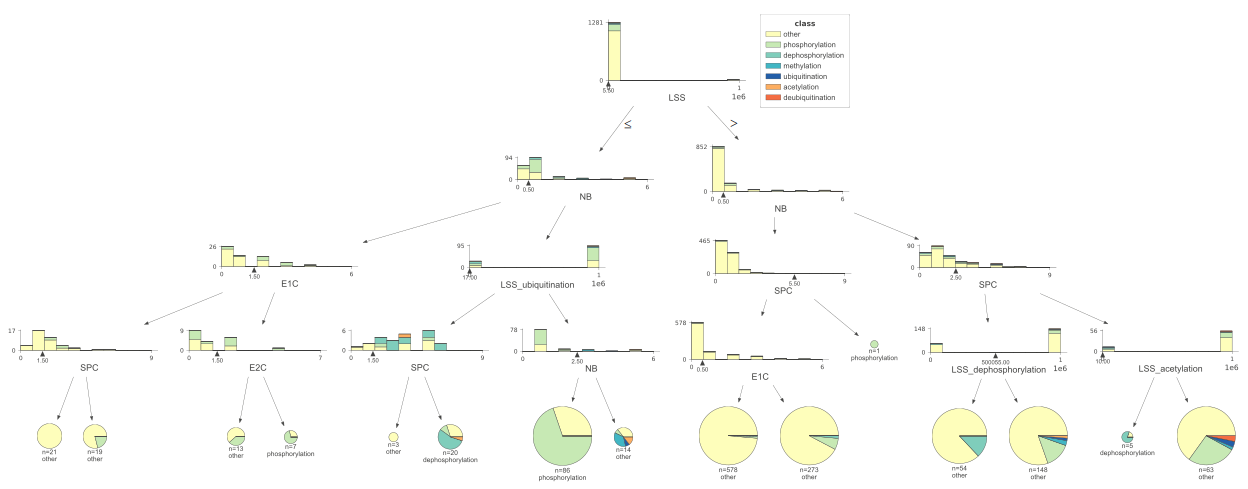

In [14]:
#plot_tree(train_result[NAIVE_BAYES_WITH_TREE]["m"])

plot_tree_pretty(train_result[NAIVE_BAYES_WITH_TREE]["m"], df_train["x"], df_train["y"])

In [15]:
get_top_discrimintary_keywords(train_result[NAIVE_BAYES]["m"],0)

[('prtig0', -2.084220300023153),
 ('protpart1', -2.209740318181689),
 ('protpart0', -2.215094431726415),
 ('prtig1', -2.257463091050905),
 ('prtig2', -2.462755220575742),
 ('prtig3', -2.637168151909769),
 ('phosphorylation', -2.6953998444999776),
 ('cells', -3.2234672747004742),
 ('kinase', -3.256101033893777),
 ('protein', -3.27705152083458),
 ('activation', -3.3085953547572897),
 ('cell', -3.4998422762375636),
 ('tyrosine', -3.7443770175330906),
 ('activity', -3.7987571005523124),
 ('proteins', -3.9226527158075015),
 ('expression', -4.227073473577245),
 ('mediated', -4.33690463273074),
 ('phosphatase', -4.5620869207347985),
 ('degradation', -4.569769416906815),
 ('mechanism', -5.0361805352320586),
 ('levels', -5.307602086812059),
 ('transcription', -5.380057166027481),
 ('rna', -5.591706337915957),
 ('acetylation', -5.851217533401041),
 ('methylation', -5.90837594724099),
 ('increases', -6.328656141134295),
 ('lysine', -6.472905749978842),
 ('arginine', -6.641528462414634),
 ('methyl

In [16]:
get_top_discrimintary_keywords(train_result[NAIVE_BAYES]["m"],1)

[('protpart1', -1.5447528604148841),
 ('protpart0', -1.6623985428672885),
 ('prtig0', -2.425952272477769),
 ('phosphorylation', -2.6746176925870984),
 ('prtig1', -2.684874192754287),
 ('kinase', -3.1007020878979983),
 ('prtig2', -3.2223990228755177),
 ('cells', -3.270601124693396),
 ('protein', -3.301951654577472),
 ('cell', -3.467848331704026),
 ('activation', -3.467848331704026),
 ('activity', -3.5460131045533627),
 ('tyrosine', -3.880860645447573),
 ('prtig3', -3.9273806610824664),
 ('proteins', -4.215062733534247),
 ('expression', -4.3151461920912295),
 ('mediated', -4.446174454497633),
 ('phosphatase', -4.831836935309618),
 ('degradation', -4.831836935309618),
 ('mechanism', -4.990901629939305),
 ('transcription', -5.313675022202357),
 ('levels', -5.4137584807593395),
 ('rna', -5.7932481024642435),
 ('increases', -6.16097288258956),
 ('acetylation', -6.566437990697725),
 ('arginine', -7.25958517125767),
 ('lysine', -7.665050279365834),
 ('methyltransferase', -8.35819745992578),
 (

## Val GT predictions


In [17]:
df_val = pd.read_json(valfile, orient="records")
result_val = train_and_predict_all_classifiers(df_val, min_df=1)

print_report_all_classifiers(df_val["y"], result_val,  pos_labels)

print_report_all_classifiers(df_val["y"], result_val,  all_labels)



Training Naive Bayes
Max words :  41
Training Naive Bayes + Tree
Training Tree
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      36.2 &   Phosphorylation &   81.0 &     50.0 &      21 \\
       Naive Bayes &      29.0 & Dephosphorylation &   90.0 &     43.9 &      10 \\
       Naive Bayes &      16.7 &       Methylation &  100.0 &     28.6 &       1 \\
       Naive Bayes &      16.7 &    Ubiquitination &  100.0 &     28.6 &       1 \\
       Naive Bayes &      33.3 &       Acetylation &  100.0 &     50.0 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      31.2 &         micro avg &   85.3 &     45.7 &      34 \\
       Naive Bayes &      22.0 &         macro avg &   78.5 &     33.5 &      34 \\
       Naive Bayes &      32.8 &      weighted avg &   85.3 &     46.9 &      34 \\
Naive Bayes + Tree &      88.9 &   Phos

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.953271,Negative,0.614458,0.747253,166.0
Phosphorylation,Naive Bayes,0.361702,Phosphorylation,0.809524,0.500000,21.0
Dephosphorylation,Naive Bayes,0.290323,Dephosphorylation,0.900000,0.439024,10.0
Methylation,Naive Bayes,0.166667,Methylation,1.000000,0.285714,1.0
Ubiquitination,Naive Bayes,0.166667,Ubiquitination,1.000000,0.285714,1.0
Acetylation,Naive Bayes,0.333333,Acetylation,1.000000,0.500000,1.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.655000,micro avg,0.655000,0.655000,200.0
macro avg,Naive Bayes,0.324566,macro avg,0.760569,0.393958,200.0
weighted avg,Naive Bayes,0.847043,weighted avg,0.655000,0.700028,200.0


## Test 

### Predict Test on Test GT fit

In [18]:
df_test = pd.read_json(testfile, orient="records")
result_test_gt = train_and_predict_all_classifiers(df_test, min_df=1)

# df_test["train_shortcut_pred"] = m.predict(df_test["x"])[0]
print_report_all_classifiers(df_test["y"], result_test_gt,  pos_labels)

print_report_all_classifiers(df_test["y"], result_test_gt, all_labels)

l_test_gt = print_report_all_classifiers(df_test["y"], result_test_gt,  pos_labels)


Training Naive Bayes
Max words :  31
Training Naive Bayes + Tree
Training Tree
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      45.2 &   Phosphorylation &   63.6 &     52.8 &      44 \\
       Naive Bayes &      19.2 & Dephosphorylation &   83.3 &     31.2 &       6 \\
       Naive Bayes &      22.2 &       Methylation &  100.0 &     36.4 &       4 \\
       Naive Bayes &      16.7 &    Ubiquitination &  100.0 &     28.6 &       1 \\
       Naive Bayes &       8.3 &       Acetylation &  100.0 &     15.4 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      31.5 &         micro avg &   69.6 &     43.3 &      56 \\
       Naive Bayes &      18.6 &         macro avg &   74.5 &     27.4 &      56 \\
       Naive Bayes &      39.6 &      weighted avg &   69.6 &     48.2 &      56 \\
Naive Bayes + Tree &      73.9 &   Phos

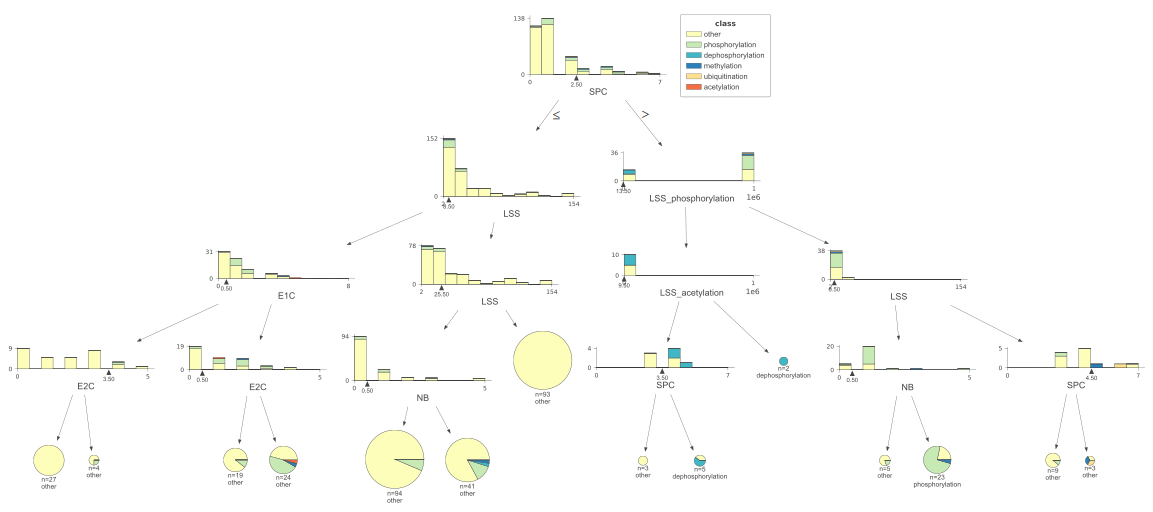

In [19]:
#plot_tree(result_test_gt[NAIVE_BAYES_WITH_TREE]["m"])

plot_tree_pretty(result_test_gt[NAIVE_BAYES_WITH_TREE]["m"], df_test["x"], df_test["y"])

### Test on train fit

In [20]:
result_train_predict_test_gt = predict_all_classifiers(df_test, result_test_gt)

print_report_all_classifiers(df_test["y"], result_train_predict_test_gt,  all_labels)



\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      93.4 &          Negative &   72.0 &     81.3 &     296 \\
       Naive Bayes &      45.2 &   Phosphorylation &   63.6 &     52.8 &      44 \\
       Naive Bayes &      19.2 & Dephosphorylation &   83.3 &     31.2 &       6 \\
       Naive Bayes &      22.2 &       Methylation &  100.0 &     36.4 &       4 \\
       Naive Bayes &      16.7 &    Ubiquitination &  100.0 &     28.6 &       1 \\
       Naive Bayes &       8.3 &       Acetylation &  100.0 &     15.4 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      71.6 &         micro avg &   71.6 &     71.6 &     352 \\
       Naive Bayes &      29.3 &         macro avg &   74.1 &     35.1 &     352 \\
       Naive Bayes &      84.9 &      weighted avg &   71.6 &     76.0 &     352 \\
Naive Bayes + Tree &      89.8 &  

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.934211,Negative,0.719595,0.812977,296.0
Phosphorylation,Naive Bayes,0.451613,Phosphorylation,0.636364,0.528302,44.0
Dephosphorylation,Naive Bayes,0.192308,Dephosphorylation,0.833333,0.312500,6.0
Methylation,Naive Bayes,0.222222,Methylation,1.000000,0.363636,4.0
Ubiquitination,Naive Bayes,0.166667,Ubiquitination,1.000000,0.285714,1.0
Acetylation,Naive Bayes,0.083333,Acetylation,1.000000,0.153846,1.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.715909,micro avg,0.715909,0.715909,352.0
macro avg,Naive Bayes,0.292908,macro avg,0.741327,0.350997,352.0
weighted avg,Naive Bayes,0.848551,weighted avg,0.715909,0.760385,352.0


### Predict Test on Test Prediction fit 

In [21]:
df_test_prediction = load_valtest_ensemble_pred(test_predictions_file)

result_test_bp = train_and_predict_all_classifiers(df_test_prediction, min_df=1)

print_report_all_classifiers(df_test_prediction["y"], result_test_bp,  pos_labels)

print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)



l_test_pred =  print_report_all_classifiers(df_test_prediction["y"], result_test_bp,  pos_labels)


Training Naive Bayes
Max words :  34
Training Naive Bayes + Tree
Training Tree
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      40.0 &   Phosphorylation &   91.7 &     55.7 &      24 \\
       Naive Bayes &      15.4 & Dephosphorylation &  100.0 &     26.7 &       2 \\
       Naive Bayes &      40.0 &       Methylation &  100.0 &     57.1 &       4 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       8.3 &       Acetylation &  100.0 &     15.4 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      32.2 &         micro avg &   93.5 &     47.9 &      31 \\
       Naive Bayes &      17.3 &         macro avg &   65.3 &     25.8 &      31 \\
       Naive Bayes &      37.4 &      weighted avg &   93.5 &     52.7 &      31 \\
Naive Bayes + Tree &      69.2 &   Phos

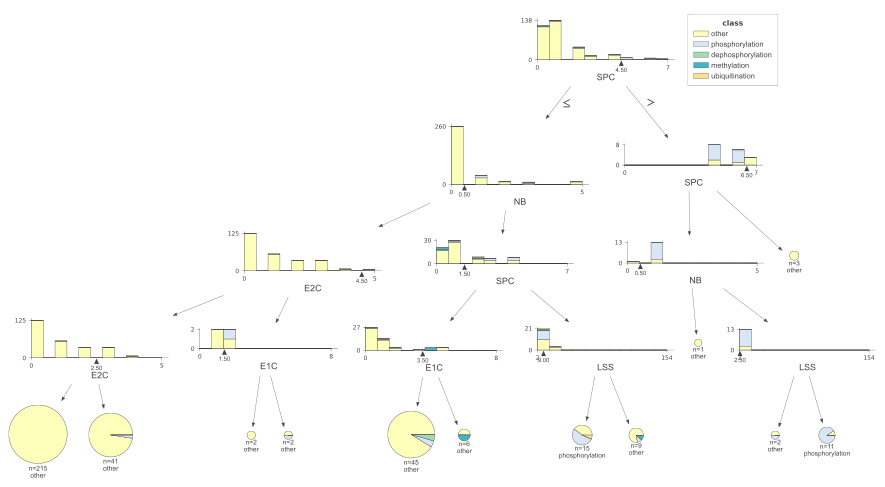

In [22]:
# plot_tree(result_test_bp[NAIVE_BAYES_WITH_TREE]["m"])
plot_tree_pretty(result_test_bp[NAIVE_BAYES_WITH_TREE]["m"], df_test_prediction["x"], df_test_prediction["y"])

In [23]:
t = l_test_pred.merge(l_test_gt,  on =["model", "index"])

print(t.to_latex(index=False, float_format= lambda x: f"{x:.1%}").replace("\%",""))

\begin{tabular}{lrlrrrrrrr}
\toprule
             model &  precision\_x &             index &  recall\_x &  f1-score\_x &  support\_x &  precision\_y &  recall\_y &  f1-score\_y &  support\_y \\
\midrule
       Naive Bayes &        40.0 &   Phosphorylation &     91.7 &       55.7 &    2400.0 &        45.2 &     63.6 &       52.8 &    4400.0 \\
       Naive Bayes &        15.4 & Dephosphorylation &    100.0 &       26.7 &     200.0 &        19.2 &     83.3 &       31.2 &     600.0 \\
       Naive Bayes &        40.0 &       Methylation &    100.0 &       57.1 &     400.0 &        22.2 &    100.0 &       36.4 &     400.0 \\
       Naive Bayes &         0.0 &    Ubiquitination &      0.0 &        0.0 &       0.0 &        16.7 &    100.0 &       28.6 &     100.0 \\
       Naive Bayes &         8.3 &       Acetylation &    100.0 &       15.4 &     100.0 &         8.3 &    100.0 &       15.4 &     100.0 \\
       Naive Bayes &         0.0 &  Deubiquitination &      0.0 &        0.0 &       0

### Test prediction on train fit

In [24]:
result_train_predict_test_bp = predict_all_classifiers(df_test_prediction, result_test_bp)

print_report_all_classifiers(df_test_prediction["y"], result_train_predict_test_bp,  all_labels)



\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      99.2 &          Negative &   81.0 &     89.2 &     321 \\
       Naive Bayes &      40.0 &   Phosphorylation &   91.7 &     55.7 &      24 \\
       Naive Bayes &      15.4 & Dephosphorylation &  100.0 &     26.7 &       2 \\
       Naive Bayes &      40.0 &       Methylation &  100.0 &     57.1 &       4 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       8.3 &       Acetylation &  100.0 &     15.4 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      82.1 &         micro avg &   82.1 &     82.1 &     352 \\
       Naive Bayes &      29.0 &         macro avg &   67.5 &     34.9 &     352 \\
       Naive Bayes &      93.8 &      weighted avg &   82.1 &     86.0 &     352 \\
Naive Bayes + Tree &      96.3 &  

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.992366,Negative,0.809969,0.891938,321.0
Phosphorylation,Naive Bayes,0.400000,Phosphorylation,0.916667,0.556962,24.0
Dephosphorylation,Naive Bayes,0.153846,Dephosphorylation,1.000000,0.266667,2.0
Methylation,Naive Bayes,0.400000,Methylation,1.000000,0.571429,4.0
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.0
Acetylation,Naive Bayes,0.083333,Acetylation,1.000000,0.153846,1.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.821023,micro avg,0.821023,0.821023,352.0
macro avg,Naive Bayes,0.289935,macro avg,0.675234,0.348692,352.0
weighted avg,Naive Bayes,0.937900,weighted avg,0.821023,0.859807,352.0


## Fit large scale Negative high quality

In [25]:

local_hq_file= os.path.join(temp_dir, s3_large_scale_high_q.split("/")[-1])

download_file(s3_large_scale_high_q , temp_dir)

t = load_large_scale(local_hq_file)


df_largescale_negative_sample_hq = pd.concat([t.query("y==0").sample(n=5000, random_state=43),
                                              t.query("y==1").sample(n=250, random_state=43)])


result_largescale_negative_sample_hq  = train_and_predict_all_classifiers(df_largescale_negative_sample_hq)



print_report_all_classifiers(df_largescale_negative_sample_hq["y"], result_largescale_negative_sample_hq, pos_labels)

print_report_all_classifiers(df_largescale_negative_sample_hq["y"], result_largescale_negative_sample_hq, all_labels)





Training Naive Bayes
Max words :  16
Training Naive Bayes + Tree
Training Tree
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      77.3 &   Phosphorylation &   95.6 &     85.5 &     250 \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      77.3 &         micro avg &   95.6 &     85.5 &     250 \\
       Naive Bayes &      12.9 &         macro avg &   15.9 &     14.3 &     250 \\
       Naive Bayes &      77.3 &      weighted avg &   95.6 &     85.5 &     250 \\
Naive Bayes + Tree &      84.8 &   Phos

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.997774,Negative,0.986000,0.991852,5000.0
Phosphorylation,Naive Bayes,0.773463,Phosphorylation,0.956000,0.855098,250.0
Dephosphorylation,Naive Bayes,0.000000,Dephosphorylation,0.000000,0.000000,0.0
Methylation,Naive Bayes,0.000000,Methylation,0.000000,0.000000,0.0
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.0
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,0.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.984571,micro avg,0.984571,0.984571,5250.0
macro avg,Naive Bayes,0.253034,macro avg,0.277429,0.263850,5250.0
weighted avg,Naive Bayes,0.987092,weighted avg,0.984571,0.985340,5250.0


In [26]:
get_top_discrimintary_keywords(result_largescale_negative_sample_hq[NAIVE_BAYES]["m"],0)

[('prtig0', -1.8536411808805777),
 ('prtig1', -2.0342106621518017),
 ('cells', -2.17648065865831),
 ('protpart1', -2.3182220830905766),
 ('prtig2', -2.3254757921070475),
 ('protpart0', -2.329122473619897),
 ('cell', -2.66198847444001),
 ('prtig3', -2.6997832511566653),
 ('expression', -2.938222547228955),
 ('prtig4', -3.04859237486556),
 ('protein', -3.561991286555691),
 ('activity', -3.881751581163088),
 ('kinase', -4.657821932261924),
 ('phosphorylation', -5.202189976796522),
 ('protein kinase', -6.131127670371444),
 ('phosphorylated', -6.231450391999314)]

In [27]:
get_top_discrimintary_keywords(result_largescale_negative_sample_hq[NAIVE_BAYES]["m"] ,1)

[('protpart1', -1.4776047936397694),
 ('protpart0', -1.489000928370639),
 ('phosphorylation', -2.2220949691414367),
 ('protein', -2.4338719537985813),
 ('kinase', -2.5621521528404756),
 ('cells', -2.6996819514316934),
 ('activity', -3.0674067315570106),
 ('phosphorylated', -3.0955776085237074),
 ('cell', -3.2169384655279742),
 ('protein kinase', -3.501042716631872),
 ('prtig0', -3.582872734879504),
 ('prtig1', -5.00869793475603),
 ('expression', -5.184588601219694),
 ('prtig2', -5.957778489453176),
 ('prtig3', -7.344072850573066),
 ('prtig4', -7.7495379586812305)]

### Fit to train

In [28]:
result_train_predict_largescale_negative_sample_hq = predict_all_classifiers(df_largescale_negative_sample_hq, train_result) 
 
print_report_all_classifiers(df_largescale_negative_sample_hq["y"], result_train_predict_largescale_negative_sample_hq, all_labels)

\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      99.6 &          Negative &   93.3 &     96.3 &    5000 \\
       Naive Bayes &      60.9 &   Phosphorylation &   77.2 &     68.1 &     250 \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      92.5 &          accuracy &   92.5 &     92.5 &       0 \\
       Naive Bayes &      22.9 &         macro avg &   24.4 &     23.5 &    5250 \\
       Naive Bayes &      97.8 &      weighted avg &   92.5 &     95.0 &    5250 \\
Naive Bayes + Tree &      96.1 &  

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.996155,Negative,0.932800,0.963437,5000.000000
Phosphorylation,Naive Bayes,0.608833,Phosphorylation,0.772000,0.680776,250.000000
Dephosphorylation,Naive Bayes,0.000000,Dephosphorylation,0.000000,0.000000,0.000000
Methylation,Naive Bayes,0.000000,Methylation,0.000000,0.000000,0.000000
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.000000
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,0.000000
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.000000
accuracy,Naive Bayes,0.925143,accuracy,0.925143,0.925143,0.925143
macro avg,Naive Bayes,0.229284,macro avg,0.243543,0.234888,5250.000000
weighted avg,Naive Bayes,0.977712,weighted avg,0.925143,0.949977,5250.000000


## Fit large scale Negative low quality

In [34]:
local_lq_file= os.path.join(temp_dir, s3_large_scale_low_q.split("/")[-1])

download_file(s3_large_scale_low_q , temp_dir)



df_largescale_negative_sample_lq = load_large_scale(local_lq_file)
df_largescale_negative_sample_lq = pd.concat([df_largescale_negative_sample_lq.query("y==0").sample(n=5000, random_state=43),
                                              df_largescale_negative_sample_lq.query("y==1").sample(n=250, random_state=43 )])


result_largescale_negative_sample_lq  = train_and_predict_all_classifiers(df_largescale_negative_sample_lq)



print_report_all_classifiers(df_largescale_negative_sample_lq["y"], result_largescale_negative_sample_lq, pos_labels)

print_report_all_classifiers(df_largescale_negative_sample_lq["y"], result_largescale_negative_sample_lq, all_labels)






Training Naive Bayes
Max words :  12
Training Naive Bayes + Tree
Training Tree
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      39.1 &   Phosphorylation &   31.6 &     35.0 &     250 \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      39.1 &         micro avg &   31.6 &     35.0 &     250 \\
       Naive Bayes &       6.5 &         macro avg &    5.3 &      5.8 &     250 \\
       Naive Bayes &      39.1 &      weighted avg &   31.6 &     35.0 &     250 \\
Naive Bayes + Tree &      76.0 &   Phos

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.966125,Negative,0.975400,0.970740,5000.0
Phosphorylation,Naive Bayes,0.391089,Phosphorylation,0.316000,0.349558,250.0
Dephosphorylation,Naive Bayes,0.000000,Dephosphorylation,0.000000,0.000000,0.0
Methylation,Naive Bayes,0.000000,Methylation,0.000000,0.000000,0.0
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.0
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,0.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.944000,micro avg,0.944000,0.944000,5250.0
macro avg,Naive Bayes,0.193888,macro avg,0.184486,0.188614,5250.0
weighted avg,Naive Bayes,0.938743,weighted avg,0.944000,0.941160,5250.0


In [35]:
get_top_discrimintary_keywords(result_largescale_negative_sample_lq[NAIVE_BAYES]["m"],0)

[('protpart0', -1.6352360166129074),
 ('protpart1', -1.6613760553249062),
 ('cells', -1.9224169615172428),
 ('prtig0', -2.1657772117099086),
 ('cell', -2.4810575895941422),
 ('activity', -2.9915144817925334),
 ('prtig1', -3.0403046459619656),
 ('human', -3.2169648392046577),
 ('protein', -3.2562163457496798),
 ('expression', -3.37510086852489),
 ('levels', -3.5085034532661927),
 ('patients', -3.5115994309713203)]

In [36]:
get_top_discrimintary_keywords(result_largescale_negative_sample_lq[NAIVE_BAYES]["m"],1)

[('protpart1', -1.2111841626372737),
 ('protpart0', -1.3261028138299755),
 ('cells', -2.5433648502745934),
 ('prtig0', -2.823273424392994),
 ('activity', -2.935540726264075),
 ('human', -3.062024873373195),
 ('cell', -3.084753124450751),
 ('levels', -3.253375836886544),
 ('patients', -3.368611100464129),
 ('protein', -3.4397873789320235),
 ('expression', -3.473123799199615),
 ('prtig1', -4.084925340305609)]

### Fit to train

In [37]:


result_train_predict_largescale_negative_sample_low_q = predict_all_classifiers(df_largescale_negative_sample_lq, train_result) 
 
print_report_all_classifiers(df_largescale_negative_sample_lq["y"], result_train_predict_largescale_negative_sample_low_q, all_labels)


\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      98.4 &          Negative &   51.9 &     68.0 &    5000 \\
       Naive Bayes &       9.6 &   Phosphorylation &   52.8 &     16.3 &     250 \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      51.9 &          accuracy &   51.9 &     51.9 &       0 \\
       Naive Bayes &      15.4 &         macro avg &   15.0 &     12.0 &    5250 \\
       Naive Bayes &      94.2 &      weighted avg &   51.9 &     65.5 &    5250 \\
Naive Bayes + Tree &      95.2 &  

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.984446,Negative,0.519000,0.679675,5000.000000
Phosphorylation,Naive Bayes,0.096280,Phosphorylation,0.528000,0.162862,250.000000
Dephosphorylation,Naive Bayes,0.000000,Dephosphorylation,0.000000,0.000000,0.000000
Methylation,Naive Bayes,0.000000,Methylation,0.000000,0.000000,0.000000
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.000000
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,0.000000
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.000000
accuracy,Naive Bayes,0.519429,accuracy,0.519429,0.519429,0.519429
macro avg,Naive Bayes,0.154389,macro avg,0.149571,0.120363,5250.000000
weighted avg,Naive Bayes,0.942153,weighted avg,0.519429,0.655065,5250.000000


## Latex results

In [45]:
def prepare_latex(meta_dict_df, index_filter=None ):#["micro avg"]
    result = []
    model_names = {NAIVE_BAYES: "NB",
                  NAIVE_BAYES_WITH_TREE:"NT",
                  TREE : "T"
    }

    for item in meta_dict_df:
        df= item.pop("df")
        if index_filter:
            df = df[df["index"].isin(index_filter)].copy(deep=True)
        df["model"] = df["model"].apply(lambda x: model_names[x])
        for i, meta in enumerate(item["meta"]):
            df.insert(i, meta["name"], meta["value"])
        result.append(df)
    df_summ = pd.concat(result)
    
    # Drop index if just one ..
    if df["index"].nunique() ==1:
        df_summ = df_summ.drop("index", axis=1)
    
    return df_summ
    

df_summ_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)

df_summ_test_gt = print_report_all_classifiers(df_test["y"], result_test_gt, all_labels)

df_summ_train = print_report_all_classifiers(df_train["y"], train_result, all_labels)
df_summ_negative_sample_lq = print_report_all_classifiers(df_largescale_negative_sample_lq["y"], result_largescale_negative_sample_lq, all_labels)

df_summ_negative_sample_hq = print_report_all_classifiers(df_largescale_negative_sample_hq["y"], result_largescale_negative_sample_hq, all_labels)




df_summ = prepare_latex ([
                {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},
     {"df": df_summ_negative_sample_lq, "meta":[{ "name": "dataset" , "value": "PTM GL"}, { "name": "T" , "value": "BP"}]},
     {"df": df_summ_negative_sample_hq, "meta":[{ "name": "dataset" , "value": "PTM GH"}, { "name": "T" , "value": "BP"}]}




                ],


              )

print(df_summ.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      99.2 &          Negative &   81.0 &     89.2 &     321 \\
       Naive Bayes &      40.0 &   Phosphorylation &   91.7 &     55.7 &      24 \\
       Naive Bayes &      15.4 & Dephosphorylation &  100.0 &     26.7 &       2 \\
       Naive Bayes &      40.0 &       Methylation &  100.0 &     57.1 &       4 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       8.3 &       Acetylation &  100.0 &     15.4 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      82.1 &         micro avg &   82.1 &     82.1 &     352 \\
       Naive Bayes &      29.0 &         macro avg &   67.5 &     34.9 &     352 \\
       Naive Bayes &      93.8 &      weighted avg &   82.1 &     86.0 &     352 \\
Naive Bayes + Tree &      96.3 &  

In [46]:
df_summ_trainfit_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_train_predict_test_bp,  all_labels)
df_summ_trainfit_test_gt = print_report_all_classifiers(df_test["y"], result_train_predict_test_gt,  all_labels)
df_summ_trainfit_large_high = print_report_all_classifiers(df_largescale_negative_sample_hq["y"], result_train_predict_largescale_negative_sample_hq,  all_labels)
df_summ_trainfit_large_low = print_report_all_classifiers(df_largescale_negative_sample_lq["y"], result_train_predict_largescale_negative_sample_low_q,  all_labels)

df_summ_train = print_report_all_classifiers(df_train["y"], train_result, all_labels)





df_summ_neg = prepare_latex ([
                    {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},


                {"df": df_summ_trainfit_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_trainfit_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},
                {"df": df_summ_trainfit_large_high, "meta":[{ "name": "dataset" , "value": "PTM GH"}, { "name": "T" , "value": "BP"}]},
                {"df": df_summ_trainfit_large_low, "meta":[{ "name": "dataset" , "value": "PTM GL"}, { "name": "T" , "value": "BP"}]},





                ],
    index_filter=["Negative"]
              )

print("**Negative***")
print(df_summ_neg.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

df_summ_phos = prepare_latex ([
                        {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},


                {"df": df_summ_trainfit_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_trainfit_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},
                {"df": df_summ_trainfit_large_high, "meta":[{ "name": "dataset" , "value": "PTM GH"}, { "name": "T" , "value": "BP"}]},
                {"df": df_summ_trainfit_large_low, "meta":[{ "name": "dataset" , "value": "PTM GL"}, { "name": "T" , "value": "BP"}]},





                ],
    index_filter=["Phosphorylation"]
              )

print("**Phosphorylation***")

print(df_summ_phos.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      99.2 &          Negative &   81.0 &     89.2 &     321 \\
       Naive Bayes &      40.0 &   Phosphorylation &   91.7 &     55.7 &      24 \\
       Naive Bayes &      15.4 & Dephosphorylation &  100.0 &     26.7 &       2 \\
       Naive Bayes &      40.0 &       Methylation &  100.0 &     57.1 &       4 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       8.3 &       Acetylation &  100.0 &     15.4 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      82.1 &         micro avg &   82.1 &     82.1 &     352 \\
       Naive Bayes &      29.0 &         macro avg &   67.5 &     34.9 &     352 \\
       Naive Bayes &      93.8 &      weighted avg &   82.1 &     86.0 &     352 \\
Naive Bayes + Tree &      96.3 &  

In [40]:
def prepare_latex(meta_dict_df):
    result = []
    model_names = {NAIVE_BAYES: "NB",
                  NAIVE_BAYES_WITH_TREE:"NBT",
                  TREE : "T"
    }

    for item in meta_dict_df:
        df= item.pop("df")
        df = df.copy(deep=True)
        df["model"] = df["model"].apply(lambda x: model_names[x])
        for i, meta in enumerate(item["meta"]):
            df.insert(i, meta["name"], meta["value"])
        result.append(df)
    df_summ = pd.concat(result)
    df_summ["index"] = df_summ["index"].apply(lambda x: label_names[int(x)] if isint(x) else x )
    
    return df_summ


df_summ_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)

df_summ_test_gt = print_report_all_classifiers(df_test["y"], result_test_gt, all_labels)

df_summ_train = print_report_all_classifiers(df_train["y"], train_result, all_labels)



df_summ = prepare_latex ([
                {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},
                ]
              )

print(df_summ.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

NameError: name 'df_largescale_hq' is not defined